In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import esm
from captum.attr import (
    IntegratedGradients,
    LayerIntegratedGradients,
    TokenReferenceBase,
)
import pandas as pd
from typing import List, Tuple, Dict, Optional, Union
import re
import os
from scipy.stats import entropy

In [2]:
!pip install fair-esm captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.

In [4]:
class ESMModelInterpreter:
    """
    A class for interpreting ESM-2 models using integrated gradients and attention visualization.
    This utility works with models trained using the ESM-2 architecture for protein classification.
    """

    def __init__(
        self,
        model_path: str,
        device: str = "cuda" if torch.cuda.is_available() else "cpu",
    ):
        """
        Initialize the interpreter with a saved model.

        Args:
            model_path: Path to the saved model checkpoint
            device: Device to run the model on ('cuda' or 'cpu')
        """
        self.device = device
        self.checkpoint = torch.load(
            model_path, map_location=device, weights_only=False
        )

        # Load the ESM model first
        self.esm_model_name = self.checkpoint.get("esm_model_name", "esm2_t6_8M_UR50D")
        self.esm_model, self.alphabet = self._load_esm_model(self.esm_model_name)
        self.batch_converter = self.alphabet.get_batch_converter()

        # Then recreate the full classifier
        self.model = self._recreate_model()
        self.model.load_state_dict(self.checkpoint["model_state_dict"])
        self.model.to(device)
        self.model.eval()

        # For token reference
        self.ref_token_id = self.alphabet.cls_idx

    def _load_esm_model(self, model_name: str):
        """Load the correct ESM model based on the name saved in the checkpoint."""
        if model_name == "esm2_t6_8M_UR50D":
            return esm.pretrained.esm2_t6_8M_UR50D()
        elif model_name == "esm2_t12_35M_UR50D":
            return esm.pretrained.esm2_t12_35M_UR50D()
        elif model_name == "esm2_t30_150M_UR50D":
            return esm.pretrained.esm2_t30_150M_UR50D()
        elif model_name == "esm2_t33_650M_UR50D":
            return esm.pretrained.esm2_t33_650M_UR50D()
        else:
            raise ValueError(f"Unknown ESM model: {model_name}")

    def _recreate_model(self):
        """Recreate the model architecture from saved hyperparameters."""
        architecture = self.checkpoint.get("model_architecture", {})
        hidden_dim = architecture.get("hidden_dim", 128)
        num_layers = architecture.get("num_layers", 1)
        dropout = architecture.get("dropout", 0.3)

        from torch import nn

        class ESMClassifier(nn.Module):
            def __init__(self, esm_model, hidden_dim=128, num_layers=1, dropout=0.3):
                super().__init__()
                self.esm = esm_model
                layers = []
                input_dim = esm_model.embed_dim

                for _ in range(num_layers):
                    layers.append(nn.Linear(input_dim, hidden_dim))
                    layers.append(nn.ReLU())
                    layers.append(nn.Dropout(dropout))
                    input_dim = hidden_dim

                layers.append(nn.Linear(hidden_dim, 1))
                self.classifier = nn.Sequential(*layers)

            def forward(self, tokens):
                results = self.esm(tokens, repr_layers=[6], return_contacts=False)
                embeddings = results["representations"][6]
                cls_rep = embeddings[:, 0, :]  # CLS token
                logits = self.classifier(cls_rep)
                return logits.squeeze(-1)

        return ESMClassifier(
            self.esm_model,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
        )

    def predict(self, sequence: str) -> float:
        """
        Make a prediction for a single protein sequence.

        Args:
            sequence: A protein sequence string

        Returns:
            Predicted probability (0-1)
        """
        batch_labels = [("protein", sequence)]
        _, _, tokens = self.batch_converter(batch_labels)
        tokens = tokens.to(self.device)

        with torch.no_grad():
            output = self.model(tokens)
            prob = torch.sigmoid(output).item()

        return prob

    def _get_attention_weights(self, sequence: str) -> torch.Tensor:
        """
        Extract attention weights from the ESM model for a sequence.

        Args:
            sequence: A protein sequence string

        Returns:
            Tensor of attention weights
        """
        batch_labels = [("protein", sequence)]
        _, _, tokens = self.batch_converter(batch_labels)
        tokens = tokens.to(self.device)

        attention_weights = None

        def hook_fn(module, input, output):
            nonlocal attention_weights
            attention_weights = output.attentions

        # Get number of attention layers
        num_layers = self.esm_model.num_layers

        # Register hook to the last attention layer
        hook = self.esm_model.layers[num_layers - 1].attention.register_forward_hook(
            hook_fn
        )

        # Forward pass
        with torch.no_grad():
            self.model(tokens)

        # Remove hook
        hook.remove()

        return attention_weights

    def visualize_attention(
        self,
        sequence: str,
        layer: int = -1,
        head: int = 0,
        save_path: Optional[str] = None,
    ):
        """
        Visualize attention weights for a sequence.

        Args:
            sequence: Protein sequence to visualize
            layer: Attention layer to visualize (-1 for last layer)
            head: Attention head to visualize
            save_path: Path to save the visualization
        """
        # Get tokens and attention weights
        batch_labels = [("protein", sequence)]
        _, _, tokens = self.batch_converter(batch_labels)
        tokens = tokens.to(self.device)

        with torch.no_grad():
            outputs = self.esm_model(
                tokens,
                repr_layers=[layer],
                return_contacts=False,
                need_head_weights=True,
            )

        # Get attention weights
        attentions = outputs["attentions"]
        if attentions is None:
            print("Attention weights not available. Try using a different ESM model.")
            return

        # Convert layer index
        layer_idx = layer if layer >= 0 else attentions.shape[1] + layer

        # Select the attention correct layer and head
        attention = attentions[0, layer_idx, head].cpu().numpy()

        # Convert tokens to amino acids for visualization
        amino_acids = []
        for token_idx in tokens[0]:
            amino_acid = self.alphabet.get_tok(token_idx.item())
            amino_acids.append(amino_acid)

        # Filter out special tokens and their attention
        valid_tokens = []
        for i, aa in enumerate(amino_acids):
            if aa not in ["<cls>", "<pad>", "<eos>", "<unk>", "<mask>"]:
                valid_tokens.append(aa)

        valid_token_indices = []
        for i, aa in enumerate(amino_acids):
            if aa not in ["<cls>", "<pad>", "<eos>", "<unk>", "<mask>"]:
                valid_token_indices.append(i)

        # Filter attention weights using valid_token_indices
        filtered_attention = attention[np.ix_(valid_token_indices, valid_token_indices)]

        # Plot with seaborn heatmap
        plt.figure(figsize=(10, 8))
        ax = sns.heatmap(
            filtered_attention,
            xticklabels=valid_tokens,
            yticklabels=valid_tokens,
            cmap="viridis",
        )
        plt.title(f"Attention Weights (Layer {layer}, Head {head})")
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)

        plt.show()

        # Return entropy of each residue's attention distribution
        entropies = [
            entropy(filtered_attention[i]) for i in range(len(filtered_attention))
        ]
        return entropies, filtered_attention, valid_tokens

    def plot_top_attention_residues(
        filtered_attention, valid_amino_acids, top_k=10, mode="received"
    ):
        """
        Plot top residues based on total attention received or sent.

        Args:
            filtered_attention (np.ndarray): Attention matrix (filtered).
            valid_amino_acids (list): List of amino acids (after filtering).
            top_k (int): Number of top residues to show.
            mode (str): 'received' or 'sent' to indicate direction of attention.
        """
        if mode == "received":
            scores = filtered_attention.sum(axis=0)  # attention received
        else:
            scores = filtered_attention.sum(axis=1)  # attention sent

        # Get top indices
        top_indices = np.argsort(scores)[-top_k:][::-1]
        top_residues = [valid_amino_acids[i] for i in top_indices]
        top_scores = scores[top_indices]

        # Plot
        plt.figure(figsize=(10, 5))
        bars = plt.bar(range(top_k), top_scores, color="darkcyan")
        plt.xticks(
            range(top_k),
            [f"{aa}-{i}" for aa, i in zip(top_residues, top_indices)],
            rotation=45,
        )
        plt.ylabel("Total Attention " + ("Received" if mode == "received" else "Sent"))
        plt.title(f"Top {top_k} Residues by Attention {mode.capitalize()}")
        plt.tight_layout()
        plt.show()

        return top_residues, top_scores

    def integrated_gradients_attributions(
        self,
        sequence: str,
        n_steps: int = 50,
        internal_batch_size: int = 5,
        save_path: Optional[str] = None,
    ) -> Tuple[np.ndarray, list, float]:
        """
        Compute attributions using embedding-level integrated gradients.
        This works by accessing the embedding layer of the ESM model directly.

        Args:
            sequence: Protein sequence to analyze
            n_steps: Number of steps in integral approximation
            internal_batch_size: Batch size for internal processing
            save_path: Path to save the visualization

        Returns:
            Tuple of (attributions, amino_acids, prediction)
        """
        # Prepare input
        batch_labels = [("protein", sequence)]
        _, _, tokens = self.batch_converter(batch_labels)
        tokens = tokens.to(self.device)

        # Extract the embedding layer
        embedding_layer = self.esm_model.embed_tokens

        # Create a wrapper model that exposes embeddings
        class EmbeddingModel(torch.nn.Module):
            def __init__(self, embedding_layer, model):
                super().__init__()
                self.embedding_layer = embedding_layer
                self.model = model

            def forward(self, embeddings):
                # Replace the embedding lookup in the original model with our input
                def hook_fn(module, input, output):
                    return embeddings

                # Register hook to override embeddings
                handle = self.embedding_layer.register_forward_hook(hook_fn)

                # Use a dummy input for token IDs - the hook will replace embeddings
                dummy_input = torch.zeros_like(tokens)
                output = self.model(dummy_input)

                # Remove hook
                handle.remove()

                return output

        embedding_model = EmbeddingModel(embedding_layer, self.model)

        # Get original embeddings
        with torch.no_grad():
            original_embeddings = embedding_layer(tokens)
            # Create a baseline of all zeros for the embedding
            baseline_embeddings = torch.zeros_like(original_embeddings)

        # Now we can use regular integrated gradients on the embeddings
        integrated_gradients = IntegratedGradients(embedding_model)

        # Get a regular prediction for comparison
        with torch.no_grad():
            pred = torch.sigmoid(self.model(tokens)).item()
            print(f"Regular prediction: {pred:.4f}")

        # Compute attributions on the embeddings
        attributions = integrated_gradients.attribute(
            original_embeddings,
            baselines=baseline_embeddings,
            n_steps=n_steps,
            internal_batch_size=internal_batch_size,
        )

        # Sum across embedding dimensions to get token-level attributions
        token_attributions = attributions.sum(dim=2).squeeze(0)
        token_attributions = token_attributions.cpu().detach().numpy()

        # Normalize attributions for visualization
        attr_sum = np.sum(np.abs(token_attributions))
        if attr_sum > 0:  # avoid division by zero
            norm_attributions = token_attributions / attr_sum
        else:
            norm_attributions = token_attributions

        # Convert tokens to amino acids
        amino_acids = []
        for token_idx in tokens[0]:
            amino_acid = self.alphabet.get_tok(token_idx.item())
            amino_acids.append(amino_acid)

        # Filter out special tokens
        valid_attributions = []
        valid_amino_acids = []
        for i, aa in enumerate(amino_acids):
            if aa not in ["<cls>", "<pad>", "<eos>", "<unk>", "<mask>"]:
                valid_attributions.append(norm_attributions[i])
                valid_amino_acids.append(aa)

        # Visualize attributions
        plt.figure(figsize=(15, 5))

        # Create bar plot with colors
        colors = ["red" if x < 0 else "blue" for x in valid_attributions]
        bars = plt.bar(range(len(valid_attributions)), valid_attributions, color=colors)

        # Add amino acid labels
        if (
            len(valid_amino_acids) <= 100
        ):  # Only show labels if sequence is not too long
            plt.xticks(
                range(len(valid_attributions)), valid_amino_acids, rotation="vertical"
            )
        else:
            plt.xticks([])  # Remove x-axis labels if too many

        plt.xlabel("Amino Acid Position")
        plt.ylabel("Attribution Score")
        plt.title(f"Integrated Gradients Attribution (Prediction: {pred:.4f})")
        plt.axhline(y=0, color="k", linestyle="-", alpha=0.3)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)

        plt.show()

        # Return the processed attributions and prediction
        return valid_attributions, valid_amino_acids, pred

    def integrated_gradients_attributions(
        self,
        sequence: str,
        n_steps: int = 50,
        internal_batch_size: int = 5,
        save_path: Optional[str] = None,
    ) -> Tuple[np.ndarray, list, float]:
        """
        Compute attributions using embedding-level integrated gradients.
        This works by accessing the embedding layer of the ESM model directly.

        Args:
            sequence: Protein sequence to analyze
            n_steps: Number of steps in integral approximation
            internal_batch_size: Batch size for internal processing
            save_path: Path to save the visualization

        Returns:
            Tuple of (attributions, amino_acids, prediction)
        """
        # Prepare input
        batch_labels = [("protein", sequence)]
        _, _, tokens = self.batch_converter(batch_labels)
        tokens = tokens.to(self.device)

        # Extract the embedding layer
        embedding_layer = self.esm_model.embed_tokens

        # Create a wrapper model that exposes embeddings
        class EmbeddingModel(torch.nn.Module):
            def __init__(self, embedding_layer, model):
                super().__init__()
                self.embedding_layer = embedding_layer
                self.model = model

            def forward(self, embeddings):
                # Replace the embedding lookup in the original model with our input
                def hook_fn(module, input, output):
                    return embeddings

                # Register hook to override embeddings
                handle = self.embedding_layer.register_forward_hook(hook_fn)

                # Use a dummy input for token IDs - the hook will replace embeddings
                dummy_input = torch.zeros_like(tokens)
                output = self.model(dummy_input)

                # Remove hook
                handle.remove()

                return output

        embedding_model = EmbeddingModel(embedding_layer, self.model)

        # Get original embeddings
        with torch.no_grad():
            original_embeddings = embedding_layer(tokens)
            # Create a baseline of all zeros for the embedding
            baseline_embeddings = torch.zeros_like(original_embeddings)

        # Now we can use regular integrated gradients on the embeddings
        integrated_gradients = IntegratedGradients(embedding_model)

        # Get a regular prediction for comparison
        with torch.no_grad():
            pred = torch.sigmoid(self.model(tokens)).item()
            print(f"Regular prediction: {pred:.4f}")

        # Compute attributions on the embeddings
        attributions = integrated_gradients.attribute(
            original_embeddings,
            baselines=baseline_embeddings,
            n_steps=n_steps,
            internal_batch_size=internal_batch_size,
        )

        # Sum across embedding dimensions to get token-level attributions
        token_attributions = attributions.sum(dim=2).squeeze(0)
        token_attributions = token_attributions.cpu().detach().numpy()

        # Normalize attributions for visualization
        attr_sum = np.sum(np.abs(token_attributions))
        if attr_sum > 0:  # avoid division by zero
            norm_attributions = token_attributions / attr_sum
        else:
            norm_attributions = token_attributions

        # Convert tokens to amino acids
        amino_acids = []
        for token_idx in tokens[0]:
            amino_acid = self.alphabet.get_tok(token_idx.item())
            amino_acids.append(amino_acid)

        # Filter out special tokens
        valid_attributions = []
        valid_amino_acids = []
        for i, aa in enumerate(amino_acids):
            if aa not in ["<cls>", "<pad>", "<eos>", "<unk>", "<mask>"]:
                valid_attributions.append(norm_attributions[i])
                valid_amino_acids.append(aa)

        # Visualize attributions
        plt.figure(figsize=(15, 5))

        # Create bar plot with colors
        colors = ["red" if x < 0 else "blue" for x in valid_attributions]
        bars = plt.bar(range(len(valid_attributions)), valid_attributions, color=colors)

        # Add amino acid labels
        if (
            len(valid_amino_acids) <= 100
        ):  # Only show labels if sequence is not too long
            plt.xticks(
                range(len(valid_attributions)), valid_amino_acids, rotation="vertical"
            )
        else:
            plt.xticks([])  # Remove x-axis labels if too many

        plt.xlabel("Amino Acid Position")
        plt.ylabel("Attribution Score")
        plt.title(f"Integrated Gradients Attribution (Prediction: {pred:.4f})")
        plt.axhline(y=0, color="k", linestyle="-", alpha=0.3)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)

        plt.show()

        # Return the processed attributions and prediction
        return valid_attributions, valid_amino_acids, pred

    def get_top_influential_residues(
        self, sequence: str, top_n: int = 10, n_steps: int = 50, absolute: bool = True
    ) -> pd.DataFrame:
        """
        Return the top influential residues based on integrated gradients.

        Args:
            sequence: Protein sequence to analyze
            top_n: Number of top residues to return
            n_steps: Number of steps in integral approximation
            absolute: If True, rank by absolute magnitude; if False, rank by actual value

        Returns:
            DataFrame with position, residue, and attribution score
        """
        # Get attributions
        attributions, amino_acids, pred = self.integrated_gradients_attributions(
            sequence, n_steps=n_steps, save_path=None
        )

        # Create dataframe
        df = pd.DataFrame(
            {
                "Position": range(1, len(attributions) + 1),
                "Residue": amino_acids,
                "Attribution": attributions,
            }
        )

        # Sort by attribution score
        if absolute:
            df["AbsAttribution"] = df["Attribution"].abs()
            df = df.sort_values("AbsAttribution", ascending=False).head(top_n)
            df = df.drop("AbsAttribution", axis=1)
        else:
            df = df.sort_values("Attribution", ascending=False).head(top_n)

        return df

    def process_multiple_sequences(
        self,
        sequences: List[str],
        ids: Optional[List[str]] = None,
        output_dir: str = "attributions",
        n_steps: int = 50,
    ) -> Dict[str, Dict]:
        """
        Process multiple sequences and save attributions.

        Args:
            sequences: List of protein sequences
            ids: List of sequence identifiers (if None, will use indices)
            output_dir: Directory to save attributions
            n_steps: Number of steps for integrated gradients

        Returns:
            Dictionary of results
        """
        if ids is None:
            ids = [f"seq_{i}" for i in range(len(sequences))]

        if len(ids) != len(sequences):
            raise ValueError("Length of ids must match length of sequences")

        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        results = {}

        for seq_id, sequence in zip(ids, sequences):
            print(f"Processing {seq_id}...")

            # Make prediction
            pred = self.predict(sequence)

            # Get attributions
            attr_path = os.path.join(output_dir, f"{seq_id}_attributions.png")
            attributions, amino_acids, _ = self.integrated_gradients_attributions(
                sequence, n_steps=n_steps, save_path=attr_path
            )

            # Get attention visualization
            attn_path = os.path.join(output_dir, f"{seq_id}_attention.png")
            entropies, attention = self.visualize_attention(
                sequence, save_path=attn_path
            )

            # Get top influential residues
            top_residues = self.get_top_influential_residues(sequence)

            results[seq_id] = {
                "prediction": pred,
                "attributions": attributions,
                "amino_acids": amino_acids,
                "top_residues": top_residues,
                "attention_entropies": entropies,
            }

            # Save top residues to CSV
            top_residues.to_csv(
                os.path.join(output_dir, f"{seq_id}_top_residues.csv"), index=False
            )

        return results

In [5]:
def load_model_for_interpretation(model_path: str) -> ESMModelInterpreter:
    """
    Convenience function to load a saved model for interpretation.

    Args:
        model_path: Path to saved model checkpoint

    Returns:
        ESMModelInterpreter instance
    """
    interpreter = ESMModelInterpreter(model_path)
    return interpreter

Analyzing single sequence...
Prediction: 0.9903
Computing integrated gradients attributions...
Regular prediction: 0.9903


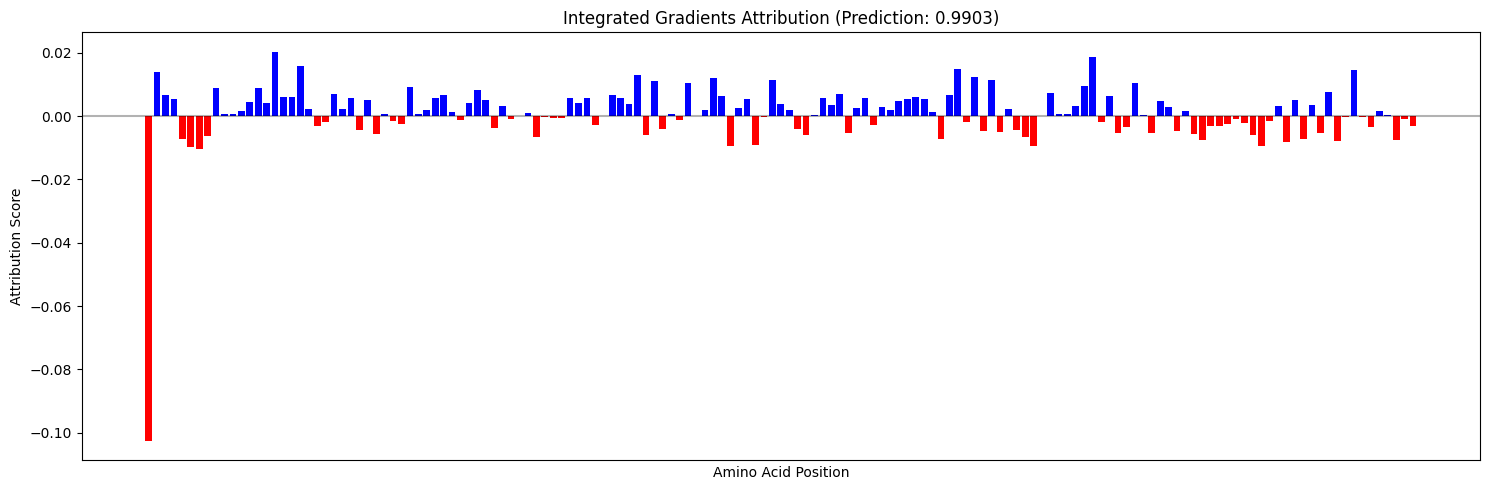

Visualizing attention...


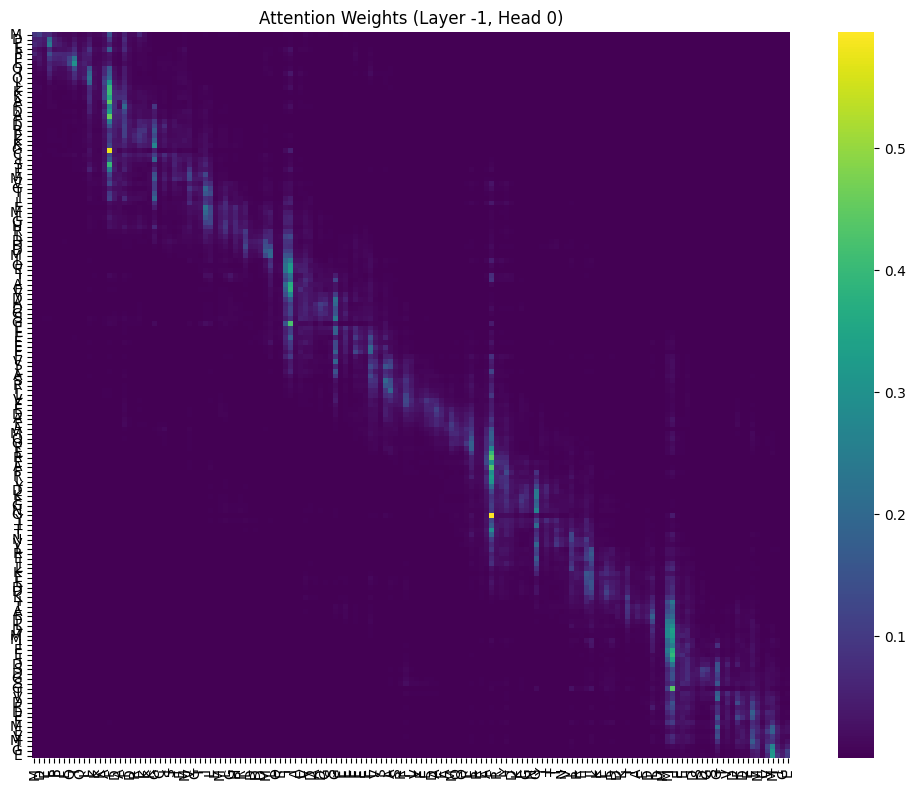

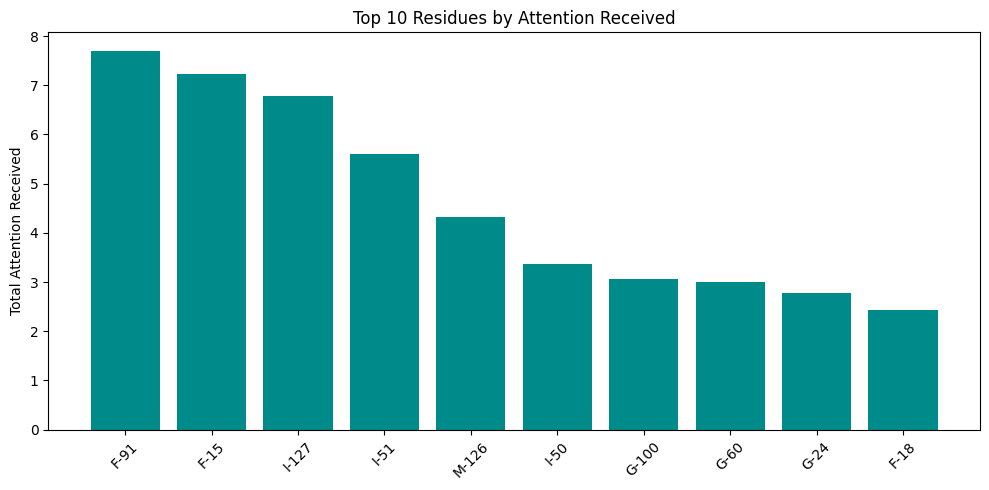

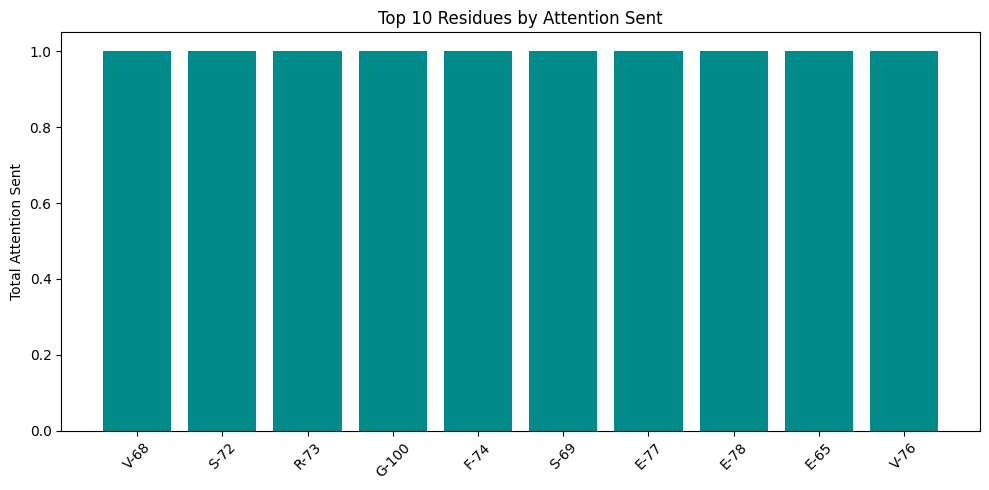

Top influential residues:
Regular prediction: 0.9903


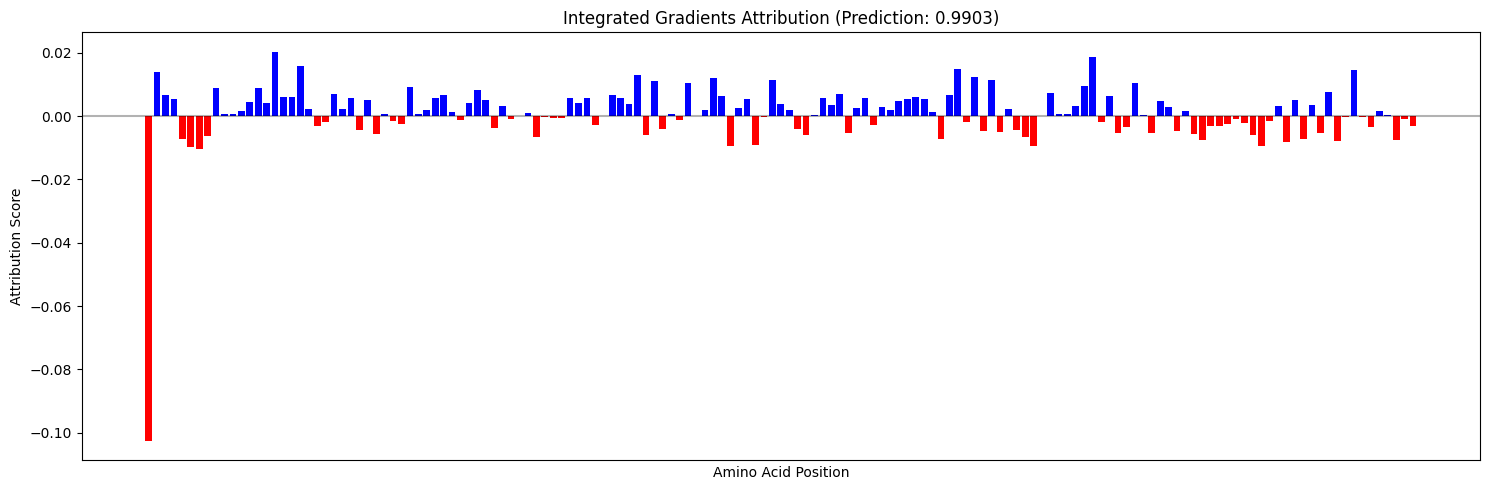

     Position Residue  Attribution
0           1       M    -0.102624
15         16       F     0.020326
112       113       K     0.018671
18         19       F     0.015795
96         97       K     0.014868
143       144       F     0.014434
1           2       D     0.014015
58         59       G     0.013019
98         99       G     0.012250
67         68       F     0.012194
Analysis complete!


In [8]:
# Load the saved model
interpreter = load_model_for_interpretation(
    "fine-tuned_esm2_allergen_classifier-final_version.pt"
)

# Example protein sequence (replace with a real sequence)
example_sequence = "MDELPPEQIQLLKKAFDAFDREKKGCISTEMVGTILEMLGHRLDDDMLQEIIAEVDADGSGELEFEEFVSLASRFLVEEDAEAMQQELREAFRLYDKEGNGYITTNVLREILKELDDKITAEDLDMMIEEIDSDGSGTVDFDEFMEVMTGE"
# Single sequence analysis
print("Analyzing single sequence...")

# Make prediction
pred = interpreter.predict(example_sequence)
print(f"Prediction: {pred:.4f}")

# Get attributions
print("Computing integrated gradients attributions...")
attributions, amino_acids, pred = interpreter.integrated_gradients_attributions(
    example_sequence, save_path="example_attributions.png"
)

# Get attention visualization
print("Visualizing attention...")
entropies, filtered_attention, valid_tokens = interpreter.visualize_attention(
    example_sequence, save_path="example_attention.png"
)
top_residues, top_scores = ESMModelInterpreter.plot_top_attention_residues(
    filtered_attention, valid_tokens, top_k=10, mode="received"
)
top_residues, top_scores = ESMModelInterpreter.plot_top_attention_residues(
    filtered_attention, valid_tokens, top_k=10, mode="sent"
)

# Get top influential residues
print("Top influential residues:")
top_residues = interpreter.get_top_influential_residues(example_sequence)
print(top_residues)


print("Analysis complete!")

In [ ]:
# Process multiple sequences from the test set

# Load the dataset
interpreter = load_model_for_interpretation("fine-tuned_esm2_allergen_classifier.pt")

sequences = [
    example_sequence,
    example_sequence[50:150],  # Just an example using a subsequence
]
ids = ["protein1", "protein2"]

print("\nProcessing multiple sequences...")
results = interpreter.process_multiple_sequences(sequences, ids, output_dir="results")

print("Analysis complete!")

/opt/anaconda3/envs/esm_interpreter_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Allergenicity prediction score: 0.0536
This protein is unlikely to be an allergen.
Regular prediction: 0.0536


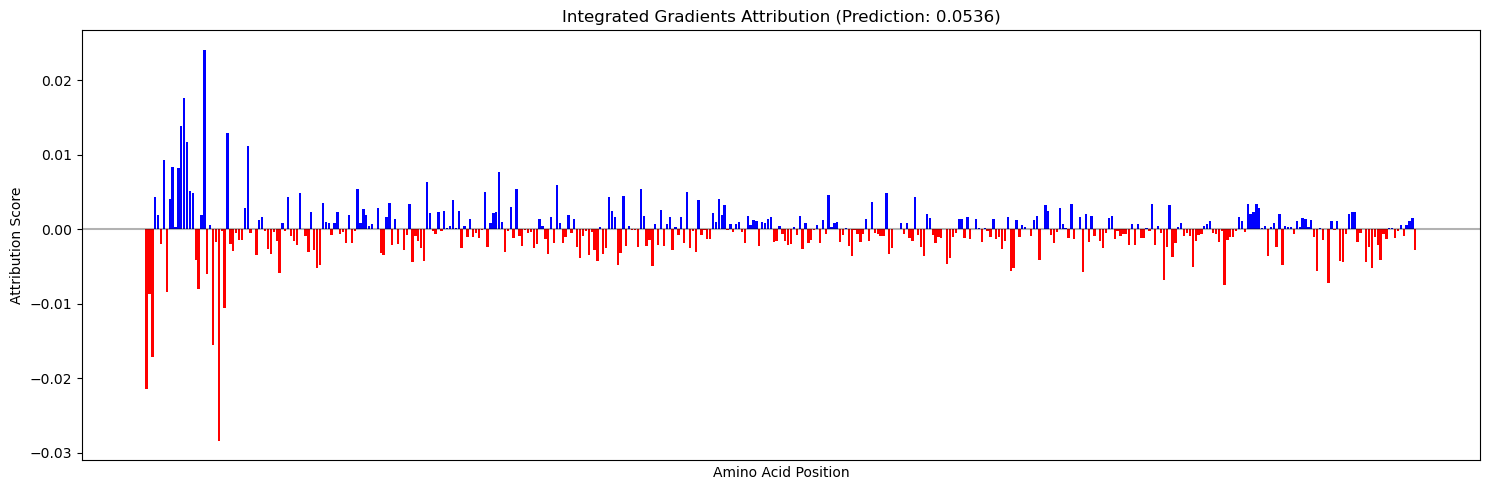

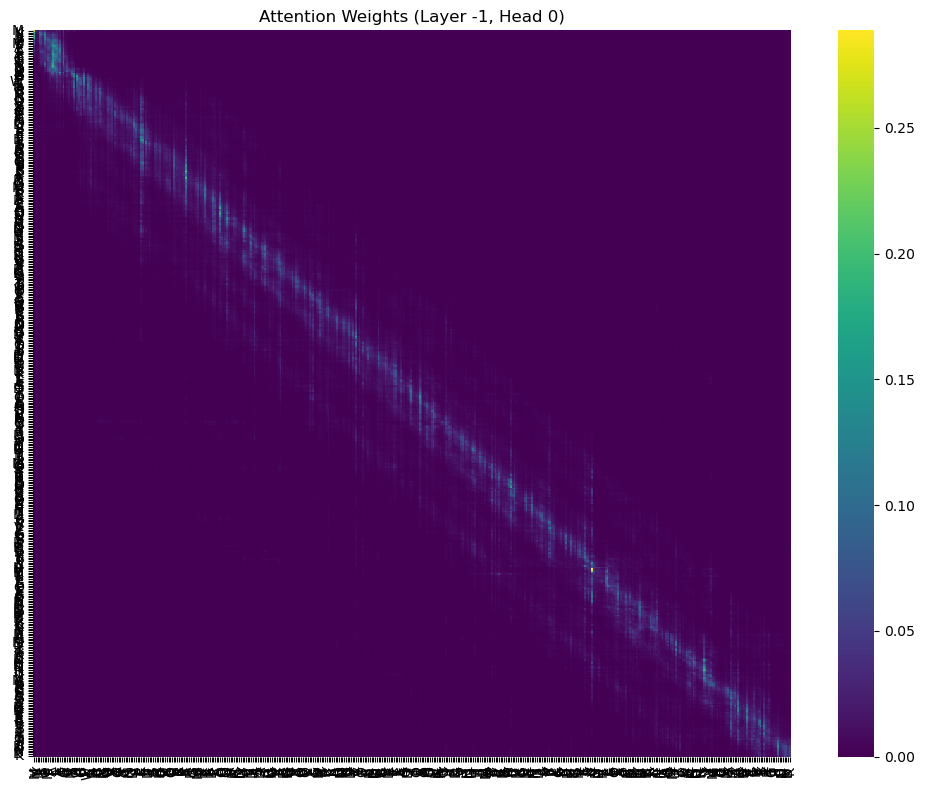

Regular prediction: 0.0536


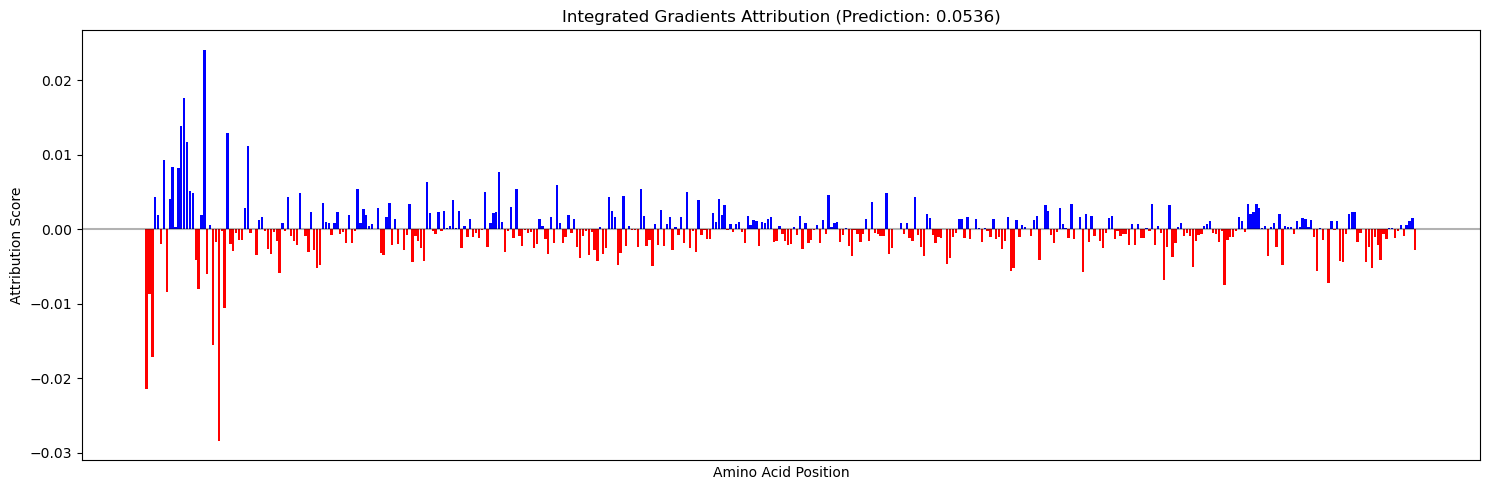


Top 20 residues influencing the prediction:
     Position Residue  Attribution
25         26       A    -0.028410
20         21       V     0.024107
0           1       M    -0.021468
13         14       F     0.017607
2           3       N    -0.017086
23         24       V    -0.015503
12         13       L     0.013860
28         29       G     0.012905
14         15       A     0.011697
35         36       R     0.011203
27         28       A    -0.010563
6           7       F     0.009356
1           2       K    -0.008703
7           8       G    -0.008435
9          10       F     0.008398
11         12       L     0.008258
18         19       G    -0.008016
122       123       Y     0.007736
373       374       Y    -0.007479
409       410       Y    -0.007270


NameError: name 'ESMModelInterpreter' is not defined

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP
import py3Dmol
from IPython.display import display, HTML
import os
import re

# Load the interpreter from your code
from ESMModelInterpreter import (
    load_model_for_interpretation,
    plot_top_attention_residues,
)


# Define the sequence
p7275_sequence = "MKNYLSFGMFALLFALTFGTVNSVQAIAGPEWLLDRPSVNNSQLVVSVAGTVEGTNQDISLKFFEIDLTSRPAHGGKTEQGLSPKSKPFATDSGAMSHKLEKADLLKAIQEQLIANVHSNDDYFEVIDFASDATITDRNGKVYFADKDGSVTLPTQPVQEFLLSGHVRVRPYKEKPIQNQAKSVDVEYTVQFTPLNPDDDFRPGLKDTKLLKTLAIGDTITSQELLAQAQSILNKNHPGYTIYERDSSIVTHDNDIFRTILPMDQEFTYRVKNREQAYRINKKSGLNEEINNTDLISEKYYVLKKGEKPYDPFDRSHLKLFTIKYVDVDTNELLKSEQLLTASERNLDFRDLYDPRDKAKLLYNNLDAFGIMDYTLTGKVEDNHDDTNRIITVYMGKRPEGENASYHLAYDKDRYTEEEREVYSYLRYTGTPIPDNPNDK"

# Load the model for interpretation
interpreter = load_model_for_interpretation(
    "fine-tuned_esm2_allergen_classifier-final_version.pt"
)

# 1. Make allergenicity prediction
pred = interpreter.predict(p7275_sequence)
print(f"Allergenicity prediction score: {pred:.4f}")
print(f"This protein is {'likely' if pred > 0.5 else 'unlikely'} to be an allergen.")

# 2. Get attributions using integrated gradients
attributions, amino_acids, _ = interpreter.integrated_gradients_attributions(
    p7275_sequence, save_path="p7275_attributions.png"
)

# 3. Get attention visualization
entropies, filtered_attention, valid_tokens = interpreter.visualize_attention(
    p7275_sequence, save_path="p7275_attention.png"
)

# 4. Find top influential residues
top_residues = interpreter.get_top_influential_residues(p7275_sequence, top_n=20)
print("\nTop 20 residues influencing the prediction:")
print(top_residues)

# Plot the top attention residues
ESMModelInterpreter.plot_top_attention_residues(
    filtered_attention, valid_tokens, top_k=15, mode="received"
)

# 5. Create a visualization with varying font sizes based on attribution scores


def create_attention_formatted_sequence(
    sequence, attributions, min_size=8, max_size=24
):
    """Create HTML with varying font sizes based on attribution scores"""
    # Get absolute values of attributions
    abs_attr = np.abs(attributions)

    # Normalize to range [0, 1]
    if abs_attr.max() > 0:
        norm_attr = abs_attr / abs_attr.max()
    else:
        norm_attr = abs_attr

    # Map to font sizes
    font_sizes = min_size + norm_attr * (max_size - min_size)

    # Create HTML
    html = ""
    for i, (aa, size, attr) in enumerate(zip(sequence, font_sizes, attributions)):
        # Color based on attribution sign (positive=blue, negative=red)
        color = "blue" if attr >= 0 else "red"
        # Add position markers every 10 residues
        if i % 10 == 0:
            html += f"<span style='color:gray; font-size:10px'>{i}</span>"

        # Add the amino acid with appropriate size and color
        html += f"<span style='font-size:{size:.1f}px; color:{color}'>{aa}</span>"

        # Add a line break every 50 characters for readability
        if (i + 1) % 50 == 0:
            html += "<br>"

    return html


# Generate the visualization
attention_html = create_attention_formatted_sequence(amino_acids, attributions)
display(
    HTML(f"<div style='font-family:monospace; line-height:1.5'>{attention_html}</div>")
)

# 6. Map attributions to 3D structure in PDB


def map_attributions_to_pdb(
    pdb_file, sequence, attributions, output_file="colored_structure.pml"
):
    """
    Generate a PyMOL script to color the protein based on attribution scores
    """
    # Normalize attribution scores to range [0, 1] for coloring
    abs_attr = np.abs(attributions)
    if abs_attr.max() > 0:
        norm_attr = abs_attr / abs_attr.max()
    else:
        norm_attr = abs_attr

    # Create PyMOL script
    with open(output_file, "w") as f:
        f.write("# PyMOL script for coloring P_7275 based on attributions\n")
        f.write("load P_7275.pdb\n")
        f.write("hide everything\n")
        f.write("show cartoon\n")
        f.write("color white\n")
        f.write("# Color residues by attribution score\n")

        for i, (aa, score) in enumerate(zip(sequence, norm_attr)):
            # Convert score to RGB color (blue for positive, red for negative)
            # The actual score is used for color intensity
            if attributions[i] >= 0:
                color = f"[0, 0, {score:.2f}]"  # Blue
            else:
                color = f"[{score:.2f}, 0, 0]"  # Red

            # PyMOL is 1-indexed
            res_idx = i + 1
            f.write(f"set_color res_color_{res_idx}, {color}\n")
            f.write(f"color res_color_{res_idx}, resi {res_idx}\n")

        # Add visualization settings
        f.write("# Visualization enhancements\n")
        f.write("set cartoon_transparency, 0.2\n")
        f.write("# Highlight top 10 residues with spheres\n")

        # Extract top 10 residues by absolute attribution
        top_indices = np.argsort(abs_attr)[-10:]
        for idx in top_indices:
            # PyMOL is 1-indexed
            res_idx = idx + 1
            f.write(f"show spheres, resi {res_idx}\n")

        f.write("# Label the top 5 residues\n")
        top_indices = np.argsort(abs_attr)[-5:]
        for idx in top_indices:
            # PyMOL is 1-indexed
            res_idx = idx + 1
            f.write(
                f"label resi {res_idx} and name CA, '{amino_acids[idx]}{res_idx}'\n"
            )

        # Final visualization settings
        f.write("set_view (\\\n")
        f.write("     0.5783,    0.5817,    0.5719,\\\n")
        f.write("    -0.7883,    0.6128,    0.0553,\\\n")
        f.write("    -0.2104,   -0.5346,    0.8184,\\\n")
        f.write("     0.0000,    0.0000, -232.4969,\\\n")
        f.write("   -31.4735,   13.9264,   33.8914,\\\n")
        f.write("   150.9125,  313.8814,  -20.0000 )\n")
        f.write("ray 1200, 900\n")
        f.write("png p7275_attention_3d.png, dpi=300\n")

    print(f"PyMOL script generated as {output_file}")
    print("To visualize, run PyMOL and execute: @colored_structure.pml")


# Generate the PyMOL script
map_attributions_to_pdb("P_7275.pdb", amino_acids, attributions)

# 7. Alternative: Interactive 3D visualization using py3Dmol


def visualize_3d_interactive(pdb_file, sequence, attributions):
    """
    Create an interactive 3D visualization using py3Dmol
    """
    # Check if PDB file exists
    if not os.path.exists(pdb_file):
        print(f"Warning: PDB file {pdb_file} not found. Using demo visualization.")
        # Use a placeholder protein if the real one isn't available
        demo_pdb = "1AKI"  # Lysozyme as an example
        view = py3Dmol.view(query=f"pdb:{demo_pdb}", width=800, height=500)
    else:
        # Load from file
        with open(pdb_file) as f:
            pdb_data = f.read()
        view = py3Dmol.view(width=800, height=500)
        view.addModel(pdb_data, "pdb")

    # Normalize attribution scores for coloring
    abs_attr = np.abs(attributions)
    if abs_attr.max() > 0:
        norm_attr = abs_attr / abs_attr.max()
    else:
        norm_attr = abs_attr

    # Set up visualization
    view.setStyle({"cartoon": {"color": "white", "opacity": 0.7}})

    # Color by attribution
    for i, (aa, score) in enumerate(zip(sequence, norm_attr)):
        # Convert score to hex color (blue for positive, red for negative)
        if attributions[i] >= 0:
            color = f"#{0:02x}{0:02x}{int(255*score):02x}"  # Blue
        else:
            color = f"#{int(255*score):02x}{0:02x}{0:02x}"  # Red

        # 1-indexed for PDB
        res_idx = i + 1
        view.addStyle({"resi": res_idx}, {"cartoon": {"color": color}})

    # Highlight top 10 residues
    top_indices = np.argsort(abs_attr)[-10:]
    for idx in top_indices:
        res_idx = idx + 1
        view.addStyle(
            {"resi": res_idx}, {"stick": {}, "sphere": {"radius": 0.5, "opacity": 0.6}}
        )

    # Set view
    view.zoomTo()
    view.spin(True)  # Enable spinning

    # Return the view
    return view


# Try to create an interactive 3D visualization
try:
    view = visualize_3d_interactive("P_7275.pdb", amino_acids, attributions)
    view.show()
except Exception as e:
    print(f"Note: Interactive 3D visualization not available: {e}")
    print("You can use the PyMOL script generated instead.")

# 8. Create a text visualization with proportional abbreviation


def create_abbreviated_sequence(sequence, attributions, threshold=0.3):
    """Create a text representation with important residues highlighted and others abbreviated"""
    # Get absolute values and normalize
    abs_attr = np.abs(attributions)
    if abs_attr.max() > 0:
        norm_attr = abs_attr / abs_attr.max()
    else:
        norm_attr = abs_attr

    # Create abbreviated sequence
    result = ""
    for i, (aa, score) in enumerate(zip(sequence, norm_attr)):
        # Position markers
        if i % 10 == 0:
            result += f"{i:4d} "

        # Important residues shown fully, others abbreviated
        if score > threshold:
            result += f"{aa}"
        else:
            result += "."

        # Line breaks
        if (i + 1) % 50 == 0:
            result += "\n"

    return result


# Generate the abbreviated representation
abbrev_seq = create_abbreviated_sequence(amino_acids, attributions)
print("\nAbbreviated sequence (dots represent less important residues):")
print(abbrev_seq)

# 9. Summary and guidance
print("\n=== ANALYSIS SUMMARY ===")
print(
    f"Allergenicity prediction: {pred:.4f} ({'likely' if pred > 0.5 else 'unlikely'} an allergen)"
)
print(f"Number of residues analyzed: {len(amino_acids)}")
print(
    f"Top contributor: {top_residues.iloc[0]['Residue']} at position {top_residues.iloc[0]['Position']}"
)
print("\nTo visualize the 3D structure:")
print("1. Install PyMOL (https://pymol.org)")
print("2. Ensure P_7275.pdb is in your working directory")
print("3. Launch PyMOL and run: @colored_structure.pml")